In [1]:
import VariationalBayes as vb
from VariationalBayes.SparseObjectives import Objective
import VariationalBayes.ExponentialFamilies as ef
import VariationalBayes.Modeling as modeling

import math

import autograd
import autograd.numpy as np
import numpy as onp

import matplotlib.pyplot as plt
%matplotlib inline

import time

from copy import deepcopy
import scipy as sp
from scipy import optimize
from scipy import stats

In [2]:
# This is a variational implementation of the hierarchical_2pl model from the Stan examples.
np.random.seed(42)

num_i = 10
num_j = 200

# mu[0] <-> log_alpha
# mu[1] <-> beta

true_params = vb.ModelParamsDict('true')
true_params.push_param(vb.VectorParam('alpha', size=num_i, lb=0))
true_params.push_param(vb.VectorParam('beta', size=num_i))
true_params.push_param(vb.VectorParam('theta', size=num_j))
true_params.push_param(vb.VectorParam('mu', size=2))
true_params.push_param(vb.PosDefMatrixParam('sigma', size=2))

prior_params = vb.ModelParamsDict('prior')
prior_params.push_param(vb.VectorParam('mu_mean', size=2, val=np.array([0., 0.])))
mu_prior_cov = np.array([[1., 0.], [0., 25.]])
prior_params.push_param(vb.PosDefMatrixParam('mu_info', size=2, val=np.linalg.inv(mu_prior_cov)))
prior_params.push_param(vb.ScalarParam('theta_mean', val=0.0))
prior_params.push_param(vb.ScalarParam('theta_var', val=1.0))
prior_params.push_param(vb.VectorParam('tau_param', size=2, val=np.array([0.1, 0.1])))
prior_params.push_param(vb.ScalarParam('lkj_param', val=4.))


In [3]:
# Set true parameters and generate data.

# y is defined as a num_i * num_j matrix.  Here, alpha and beta are num_i vectors and
# theta is the num_j vector.  Practically we expect num_j >> num_i.
# Combine vectors in the appropriate way to match the shape of y.
def get_logit_p_term(alpha, beta, theta):
    return (np.expand_dims(theta, 0) - np.expand_dims(beta, 1)) * np.expand_dims(alpha, 1)

true_params['alpha'].set(np.exp(np.random.random(num_i)))
true_params['beta'].set(np.random.random(num_i) - 0.5)
true_params['theta'].set(np.random.random(num_j) - 0.5)
true_params['mu'].set(np.random.random(2))
true_params['sigma'].set(np.eye(2))

logit_p = get_logit_p_term(alpha=true_params['alpha'].get(),
                           beta=true_params['beta'].get(),
                           theta=true_params['theta'].get())
y_prob = sp.special.expit(logit_p)
y = sp.stats.bernoulli.rvs(y_prob)
print(y.shape)


(10, 200)


In [4]:
vb_params = vb.ModelParamsDict('params')
vb_params.push_param(vb.UVNParamVector('log_alpha', length=num_i))
vb_params.push_param(vb.UVNParamVector('beta', length=num_i))
vb_params.push_param(vb.UVNParamVector('theta', length=num_j))
vb_params.push_param(vb.MVNParam('mu', dim=2))
vb_params.push_param(vb.WishartParam('sigma_inv', size=2))

vb_init_par = vb_params.get_free()


In [5]:
class Model(object):
    def __init__(self, y, vb_params, prior_params, num_draws):
        self.y = deepcopy(y)
        self.vb_params = deepcopy(vb_params)
        self.prior_params = deepcopy(prior_params)
        self.std_draws = modeling.get_standard_draws(num_draws)
        
        self.num_i = self.vb_params['log_alpha'].mean.size()
        self.num_j = self.vb_params['theta'].mean.size()

    def get_e_log_data_likelihood(self):
        # P(y = 1) = expit(z)
        log_alpha = self.vb_params['log_alpha']
        beta = self.vb_params['beta']
        theta = self.vb_params['theta']

        e_z = get_logit_p_term(alpha=log_alpha.e_exp(), beta=beta.e(), theta=theta.e())

        # var_z = E[alpha^2] * (Var(beta) + Var(theta)) +
        #         Var(alpha) * (E[beta^2] - 2 E[beta] E[theta] + E[theta^2])

        var_alpha = np.expand_dims(log_alpha.var_exp(), 1)
        e2_alpha = np.expand_dims(log_alpha.e2_exp(), 1)

        var_beta = np.expand_dims(beta.var(), 1)
        e2_beta = np.expand_dims(beta.e_outer(), 1)
        e_beta = np.expand_dims(beta.e(), 1)

        var_theta = np.expand_dims(theta.var(), 0)
        e2_theta = np.expand_dims(theta.e_outer(), 0)
        e_theta = np.expand_dims(theta.e(), 0)

        var_z = e2_alpha * (var_beta + var_theta) + \
                var_alpha *(e2_beta - 2 * e_beta * e_theta + e2_theta)
        
        y_logit_term = modeling.get_e_logistic_term(self.y, e_z, np.sqrt(var_z), self.std_draws)

        return y_logit_term
    
    def get_e_log_hierarchy_likelihood(self):
        log_alpha = self.vb_params['log_alpha']
        beta = self.vb_params['beta']
        mu = self.vb_params['mu']
        sigma_inv = self.vb_params['sigma_inv']

        # Refer to the combined (log_alpha, beta) vector as 'ab'.
        e_ab = np.array([ log_alpha.e(), beta.e() ])
        e_outer_ab = np.array([[ log_alpha.e_outer(),      beta.e() * log_alpha.e() ],
                               [ beta.e() * log_alpha.e(), beta.e_outer() ] ])

        e_sigma_inv = sigma_inv.e()
        
        # TODO: are the two einsums for the cross term actually necessary?
        return -0.5 * (np.einsum('ij,ji', e_sigma_inv, mu.e_outer()) * self.num_i - \
                       np.einsum('i,ij,jn->', mu.e(), e_sigma_inv, e_ab) - \
                       np.einsum('in,ij,j->', e_ab, e_sigma_inv, mu.e()) + \
                       np.einsum('ij,jin->', e_sigma_inv, e_outer_ab)) + \
               0.5 * sigma_inv.e_log_det() * self.num_i
        
    def get_e_log_prior(self):
        mu = self.vb_params['mu']
        theta = self.vb_params['theta']
        sigma_inv = self.vb_params['sigma_inv']
        
        prior_params = self.prior_params
        
        e_log_prior = 0.
        
        # Mu
        e_log_prior += ef.mvn_prior(
            prior_params['mu_mean'].get(), prior_params['mu_info'].get(),
            mu.e(), mu.cov())

        # Theta
        e_log_prior += np.sum(ef.uvn_prior(
            prior_params['theta_mean'].get(), prior_params['theta_var'].get(),
            theta.e(), theta.var()))
        
        # Sigma
        e_log_prior += np.sum(ef.exponential_prior(
            prior_params['tau_param'].get(), np.diag(sigma_inv.e_inv())))
        e_log_prior += sigma_inv.e_log_lkj_inv_prior(prior_params['lkj_param'].get())
        
        return e_log_prior
    
    def get_e_log_likelihood(self):
        return \
            self.get_e_log_data_likelihood() + \
            self.get_e_log_hierarchy_likelihood() + \
            self.get_e_log_prior()

    def get_entropy(self):
        return \
            self.vb_params['log_alpha'].entropy() + \
            self.vb_params['beta'].entropy() + \
            self.vb_params['theta'].entropy() + \
            self.vb_params['mu'].entropy() + \
            self.vb_params['sigma_inv'].entropy()

    def get_kl(self):
        return -1 * (self.get_e_log_likelihood() + self.get_entropy())

    def get_negative_e_log_likelihood(self):
        # For debugging
        self.vb_params['log_alpha'].info.set(np.full(self.num_i, 100.))
        self.vb_params['beta'].info.set(np.full(self.num_i, 100.))
        self.vb_params['theta'].info.set(np.full(self.num_j, 100.))
        self.vb_params['mu'].info.set(np.eye(2) * 100.)
        self.vb_params['sigma_inv'].params['v'].set(np.eye(2) * 0.1)
        self.vb_params['sigma_inv'].params['df'].set(5.0)
        #print(self.vb_params)
        return -1 * self.get_e_log_likelihood()



In [6]:
model = Model(y, vb_params, prior_params, 10)
objective = Objective(model.vb_params, model.get_kl)
# objective = Objective(model.vb_params, model.get_negative_e_log_likelihood) # Debugging
objective.logger.print_every = 10
objective.fun_free(vb_init_par)

array([ 3356.3713254])

In [7]:
print('Running BFGS')
vb_opt_bfgs = optimize.minimize(
    lambda par: objective.fun_free(par, verbose=True), vb_init_par,
    method='bfgs', jac=objective.fun_free_grad, tol=1e-6)


print('Running Newton Trust Region')
vb_opt = optimize.minimize(
    lambda par: objective.fun_free(par, verbose=True), vb_opt_bfgs.x,
    method='trust-ncg', jac=objective.fun_free_grad, hessp=objective.fun_free_hvp, tol=1e-6)
print('Done.')

vb_opt_par = deepcopy(vb_opt.x)

Running BFGS
Iter  0  value:  [ 3356.3713254]


/home/rgiordan/Documents/git_repos/autograd/autograd/core.py:83: RuntimeWarning: overflow encountered in exp
  result_value = self.fun(*argvals, **kwargs)
/home/rgiordan/Documents/git_repos/autograd/autograd/core.py:83: RuntimeWarning: invalid value encountered in multiply
  result_value = self.fun(*argvals, **kwargs)
/home/rgiordan/Documents/git_repos/autograd/autograd/core.py:83: RuntimeWarning: overflow encountered in exp
  result_value = self.fun(*argvals, **kwargs)


Iter  10  value:  [ 2097.68747915]
Iter  20  value:  [ 1883.60066536]
Iter  30  value:  [ 1594.35313211]
Iter  40  value:  [ 1236.39944513]
Iter  50  value:  [ 1172.30379393]
Iter  60  value:  [ 1152.58946407]
Iter  70  value:  [ 1141.97888546]
Iter  80  value:  [ 1137.28117094]
Iter  90  value:  [ 1134.80809894]
Iter  100  value:  [ 1133.689131]
Iter  110  value:  [ 1133.15718364]
Iter  120  value:  [ 1132.74371341]
Iter  130  value:  [ 1132.53327524]
Iter  140  value:  [ 1132.4144536]
Iter  150  value:  [ 1132.31522251]
Iter  160  value:  [ 1132.22960368]
Iter  170  value:  [ 1132.16908289]
Iter  180  value:  [ 1132.13237606]
Iter  190  value:  [ 1132.09662641]
Iter  200  value:  [ 1132.05431135]
Iter  210  value:  [ 1132.01670975]
Iter  220  value:  [ 1131.97425189]
Iter  230  value:  [ 1131.92595363]
Iter  240  value:  [ 1131.88670296]
Iter  250  value:  [ 1131.85461912]
Iter  260  value:  [ 1131.82259233]
Iter  270  value:  [ 1131.78814867]
Iter  280  value:  [ 1131.75411238]
Iter

In [8]:
model.vb_params.set_free(vb_opt_bfgs.x)
print(model.vb_params)

params:
	log_alpha:
log_alpha_mean:
[-0.7131718   4.96401356 -0.62827503 -1.45554932 -2.34451627 -1.3483055
 -2.09274497 -0.53739096 -1.41257362 -2.04057735]
log_alpha_info:
[  19.00091535  365.75805899   25.70854169    7.57038287    2.75881192
    8.48380434    3.47699542   17.78484381    6.67038614    3.5420405 ]
	beta:
beta_mean:
[-1.02894966  0.57953025  1.25362463 -1.19713022 -0.53105835 -1.14914531
 -0.89167928  0.01289225 -0.79213492 -0.79004734]
beta_info:
[   9.90086687  360.5799305    10.53634359    4.4334451     2.81201221
    4.87517752    3.08644383   13.76251029    4.80599873    3.18514736]
	theta:
theta_mean:
[-0.46823989 -0.2776195  -0.41217145 -0.31583391 -0.55551727  1.30489819
 -0.61705752 -0.42669648 -0.45773856 -0.47110095 -0.37839422 -0.30736106
 -0.31248269  1.49846935 -0.1253803   1.27200596 -0.43347297 -0.35861755
 -0.44824011  1.09284073 -0.81926398 -0.39112758 -0.37405442  1.09926706
  1.11486256  1.09972171 -0.30798991 -0.48788321  1.24053564 -0.37909315
 -0

[-0.62418065 -0.43196859]
[-0.41913883 -0.56509069]


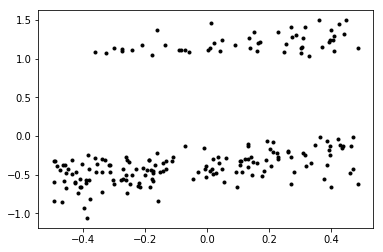

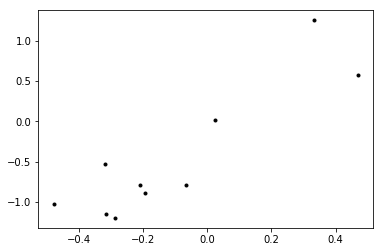

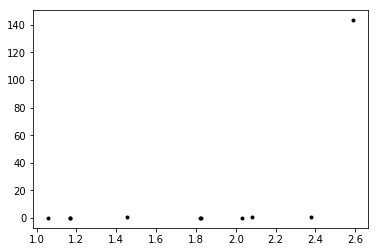

In [9]:
model.vb_params.set_free(vb_opt_par)
# print(model.vb_params)

print(model.vb_params['mu'].e())
print(np.log(true_params['mu'].get()))

# print(model.vb_params['log_alpha'])
# print(np.log(true_params['alpha'].get()))

# print(model.vb_params['beta'])
# print(true_params['beta'])

plt.figure()
plt.plot(true_params['theta'].get(), model.vb_params['theta'].e(), 'k.')

plt.figure()
plt.plot(true_params['beta'].get(), model.vb_params['beta'].e(), 'k.')

plt.figure()
plt.plot(true_params['alpha'].get(), model.vb_params['log_alpha'].e_exp(), 'k.')

In [10]:
model.vb_params.set_free(vb_opt.x)

#model.vb_params['log_alpha'].info.set(np.full(num_i, 10.0))
print(model.get_entropy())
print(model.vb_params['log_alpha'].entropy())

model.vb_params['log_alpha'].info.set(np.full(num_i, 1.0))
print(model.get_entropy())
print(model.vb_params['log_alpha'].entropy())

#print(vb_params)

[ 198.0179488]
1.91069475802
[ 210.29663937]
14.189385332
